In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2_contingency
import joblib
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import chi2_contingency

In [3]:
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (9,5)

In [4]:
CSV_PATH = "Processed_Flipdata.csv"
df = pd.read_csv(CSV_PATH)

In [5]:
for c in ['Unnamed: 0','index']:
    if c in df.columns:
        df = df.drop(columns=[c])

In [6]:
threshold = 0.5 * len(df)
removed_cols = [c for c in df.columns if df[c].count() < threshold]
print("Dropped columns (<50% non-null):", removed_cols)
df = df.dropna(thresh=threshold, axis=1)


Dropped columns (<50% non-null): []


In [7]:
df['Prize'] = df['Prize'].astype(str).str.replace(',','').str.replace('₹','').str.strip()
df['Prize'] = pd.to_numeric(df['Prize'], errors='coerce')

In [8]:


print('Shape:', df.shape)
df.head()

Shape: (541, 11)


,Model,Colour,Memory,RAM,Battery_,Rear Camera,Front Camera,AI Lens,Mobile Height,Processor_,Prize
0,Infinix SMART 7,Night Black,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
1,Infinix SMART 7,Azure Blue,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
2,MOTOROLA G32,Mineral Gray,128,8,5000,50MP,16MP,0,16.64,Qualcomm Snapdragon 680,11999
3,POCO C50,Royal Blue,32,2,5000,8MP,5MP,0,16.56,Mediatek Helio A22,5649
4,Infinix HOT 30i,Marigold,128,8,5000,50MP,5MP,1,16.76,G37,8999


In [9]:
X = df.drop(columns=['Prize'])
y = df['Prize']

In [10]:
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

In [11]:
num_imp = SimpleImputer(strategy='median')
cat_imp = SimpleImputer(strategy='most_frequent')
if num_cols:
    X[num_cols] = num_imp.fit_transform(X[num_cols])
if cat_cols:
    X[cat_cols] = cat_imp.fit_transform(X[cat_cols])

In [12]:
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

In [13]:
print('After preprocessing:', X.shape)

After preprocessing: (541, 612)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (432, 612) Test shape: (109, 612)


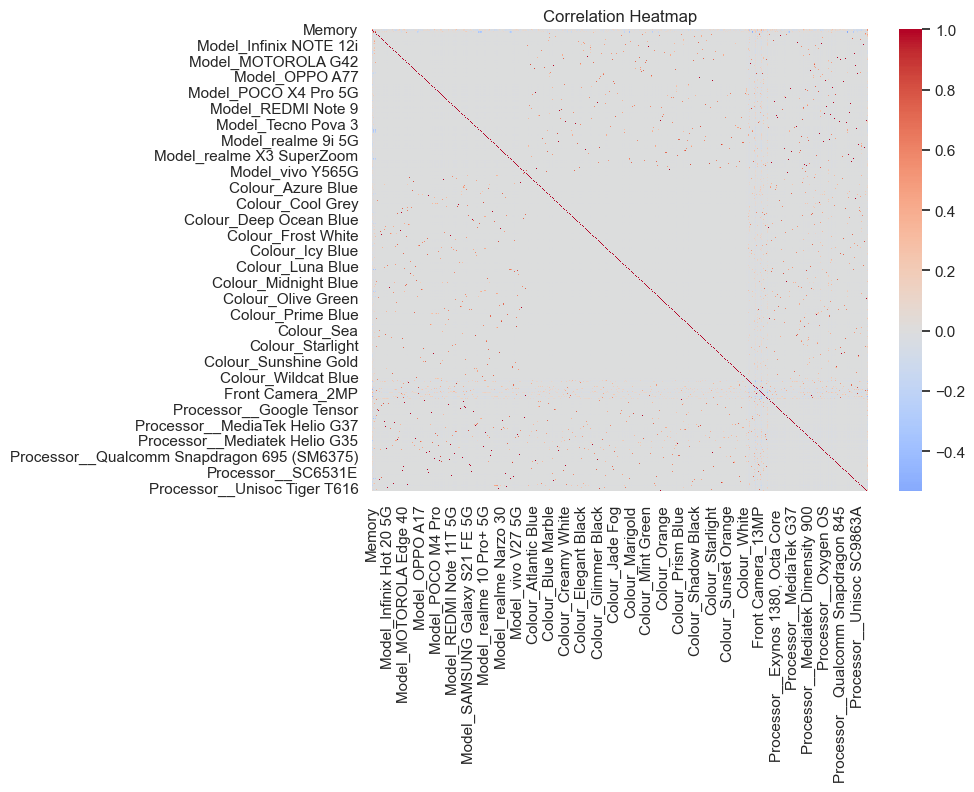

In [15]:
corr = pd.concat([X, y], axis=1).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

In [16]:
corr_target = corr['Prize'].drop('Prize').sort_values(ascending=False)
print('Top correlated features with Prize:')
print(corr_target.head(10))

Top correlated features with Prize:
Memory                         0.566660
RAM                            0.532024
Front Camera_12MP              0.525110
Model_APPLE iPhone 14 Plus     0.448522
Rear Camera_12MP               0.414096
Processor__ios                 0.294330
Front Camera_32MP              0.281776
Processor__Google Tensor G2    0.275402
Model_Google Pixel 7           0.275402
Colour_Purple                  0.258474
Name: Prize, dtype: float64


In [17]:
print(df.columns)


Index(['Model', 'Colour', 'Memory', 'RAM', 'Battery_', 'Rear Camera',
       'Front Camera', 'AI Lens', 'Mobile Height', 'Processor_', 'Prize'],
      dtype='object')


In [18]:
df['Processor_'] = df['Processor_'].astype(str).str.replace('_', ' ').str.strip()
df['Processor_'] = df['Processor_'].replace({
    'ios': 'iOS',
    'Processor ios': 'iOS',
    'Google Tensor G2': 'Google Tensor G2',
    'Processor Google Tensor G2': 'Google Tensor G2',
    'Snapdragon 8 Gen 1': 'Snapdragon',
    'Snapdragon 888': 'Snapdragon',
    'Apple Bionic A15': 'Apple Bionic',
    'Apple A15 Bionic': 'Apple Bionic'
})

df['Processor_'] = df['Processor_'].str.strip()


In [19]:
cat_cols = ['Model', 'Colour', 'Processor_']
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y_binned = discretizer.fit_transform(df['Prize'].values.reshape(-1, 1)).astype(int).ravel()

chi2_results = []
for col in cat_cols:
    cont = pd.crosstab(df[col], y_binned)
    chi2, p, _, _ = chi2_contingency(cont)
    chi2_results.append((col, p))

chi2_results = sorted(chi2_results, key=lambda x: x[1])
chi2_results

[('Model', np.float64(6.229911091246423e-97)),
 ('Processor_', np.float64(1.0438434729544212e-95)),
 ('Colour', np.float64(5.125988513999331e-12))]

In [20]:
k = min(10, X.shape[1])
skb = SelectKBest(score_func=f_regression, k=k)
skb.fit(X_train, y_train)
skb_scores = pd.Series(skb.scores_, index=X_train.columns).sort_values(ascending=False)
print('\nTop features (SelectKBest):')
print(skb_scores.head(k))


Top features (SelectKBest):
Memory                         188.384311
RAM                            186.507197
Front Camera_12MP              103.373494
Front Camera_5MP                91.871248
Model_APPLE iPhone 14 Plus      91.460845
Rear Camera_12MP                81.581066
Processor__Google Tensor G2     47.319241
Model_Google Pixel 7            47.319241
Front Camera_32MP               45.364332
Processor__6 Core               41.229406
dtype: float64


In [21]:
lr = LinearRegression()
rfe = RFE(estimator=lr, n_features_to_select=min(10, X_train.shape[1]))
rfe.fit(X_train, y_train)
selected_rfe = list(X_train.columns[rfe.support_])
print('\nTop features by RFE:')
print(selected_rfe)


Top features by RFE:
['Model_APPLE iPhone 14 Plus', 'Model_Google Pixel 7', 'Colour_Frost Blue', 'Front Camera_10MP', 'Front Camera_12MP', 'Front Camera_32MP', 'Processor__Google Tensor G2', 'Processor__Mediatek Dimensity 7200 5G', 'Processor__Qualcomm Snapdragon 8+ Gen 1', 'Processor__Tensor G2']


In [22]:
rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [23]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}')

MAE: 1785.77, RMSE: 4707.15, R2: 0.839


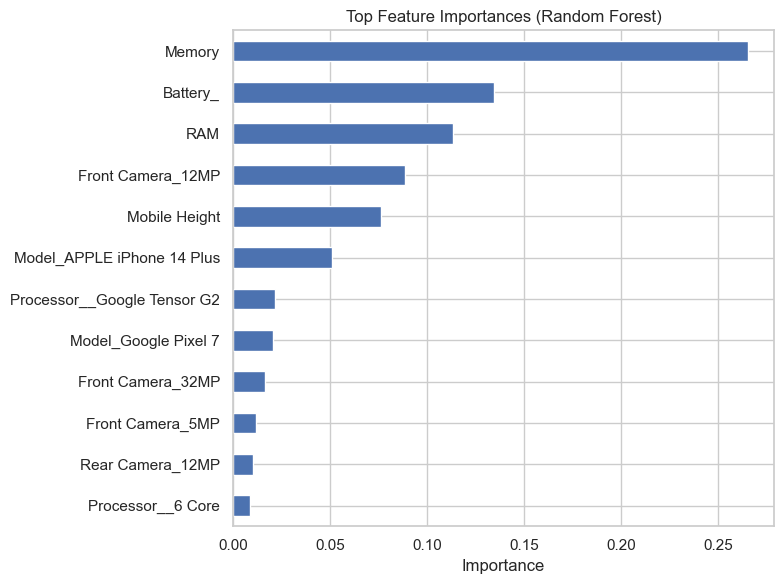

In [24]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
importances.head(12)[::-1].plot(kind='barh')
plt.title('Top Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [25]:
print('Top 10 important features:')
print(importances.head(10))

Top 10 important features:
Memory                         0.265715
Battery_                       0.134436
RAM                            0.113357
Front Camera_12MP              0.088717
Mobile Height                  0.076550
Model_APPLE iPhone 14 Plus     0.050930
Processor__Google Tensor G2    0.021770
Model_Google Pixel 7           0.020653
Front Camera_32MP              0.016507
Front Camera_5MP               0.011850
dtype: float64


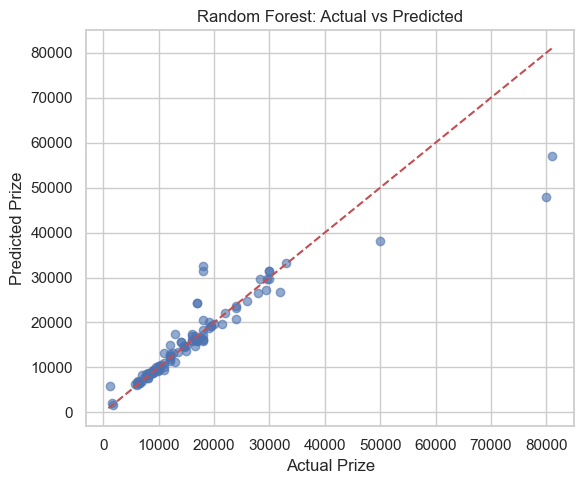

In [26]:
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()],[y.min(), y.max()], 'r--')
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual Prize')
plt.ylabel('Predicted Prize')
plt.tight_layout()
plt.show()

In [27]:
print("✅ PROJECT COMPLETED SUCCESSFULLY ✅")
print("------------------------------------------------------------")
print("Model Used        : Random Forest Regressor")
print("Evaluation Metrics:")
print(f"   → Mean Absolute Error (MAE): {mae:.2f}")
print(f"   → Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"   → R² Score: {r2:.3f}")
print("------------------------------------------------------------")
print("Top 5 Important Features:")
print(importances.head(5))
print("------------------------------------------------------------")
print("Model saved as: 'final_random_forest_model.joblib'")
print("You can load and use this model to predict prices for new phone data.")
print("------------------------------------------------------------")


✅ PROJECT COMPLETED SUCCESSFULLY ✅
------------------------------------------------------------
Model Used        : Random Forest Regressor
Evaluation Metrics:
   → Mean Absolute Error (MAE): 1785.77
   → Root Mean Squared Error (RMSE): 4707.15
   → R² Score: 0.839
------------------------------------------------------------
Top 5 Important Features:
Memory               0.265715
Battery_             0.134436
RAM                  0.113357
Front Camera_12MP    0.088717
Mobile Height        0.076550
dtype: float64
------------------------------------------------------------
Model saved as: 'final_random_forest_model.joblib'
You can load and use this model to predict prices for new phone data.
------------------------------------------------------------


In [29]:
print("\n📌 RECOMMENDATIONS FOR COMPANY 📌")
print("---------------------------------------")
print("1️⃣ Focus on improving high-impact features such as Model, Memory, and Camera Quality.")
print("2️⃣ Increase marketing for models with high RAM & Memory because they strongly increase price.")
print("3️⃣ Battery capacity influences price moderately, so highlight long battery life in campaigns.")
print("4️⃣ Processor type influences price — premium processors should be used in flagship models.")
print("---------------------------------------")



📌 RECOMMENDATIONS FOR COMPANY 📌
---------------------------------------
1️⃣ Focus on improving high-impact features such as Model, Memory, and Camera Quality.
2️⃣ Increase marketing for models with high RAM & Memory because they strongly increase price.
3️⃣ Battery capacity influences price moderately, so highlight long battery life in campaigns.
4️⃣ Processor type influences price — premium processors should be used in flagship models.
---------------------------------------


In [28]:
print("✨ Thank you for reviewing my project! ✨")

✨ Thank you for reviewing my project! ✨
